# Speak Feel: Model Building and Evaluation   

**Bach Le, Kien Tran, Sauryanshu Khanal, Sike Ogieva**

Emotion Recognition has important applications in natural language processing and human computer interaction.
Here, we build and train a neural network to classify human speech data by emotion.   

Dataset:   
https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio?resource=download

Project Milestones:   
https://github.com/sauryanshu55/Speech-Recognition 

---

**Imports and Helper Functions**

In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    classification_report,
)
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import ( 
    Activation,
    BatchNormalization,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    LSTM,
    MaxPool1D,
    MaxPooling1D,  
)
from tensorflow.keras.utils import to_categorical

In [2]:
emotion_list = {
    0: "neutral",
    1: "calm",
    2: "happy",
    3: "sad",
    4: "angry",
    5: "fearful",
    6: "disgusted",
    7: "surprised",
}


def extract_mfcc(audio):
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=40).T, axis=0)
    return mfccs


def plot_network_history(network_history):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes[0].plot(network_history.history["loss"], label="Training Loss")
    axes[0].plot(network_history.history["val_loss"], label="Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].plot(network_history.history["categorical_accuracy"], label="Training Accuracy")
    axes[1].plot(network_history.history["val_categorical_accuracy"], label="Validation Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.show()

**Load The Data**

Earlier, we augmented the training audio files from 1_152 files to 12_000 files, and now we load them and their labels along with 288 test data files (and their labels) to begin building, training and evaluating our models.
We begin by extracting Mel-Frequency Cepstral Coefficients from the audio files, and categorically encoding the labels.

In [3]:
# load the augmented data from my computer
with open("./data/processed_data.pickle", "rb") as f:
    data = pickle.load(f)
    
X_train = data['X_train']
X_test  = data['X_test']
Y_train = data['Y_train']
Y_test  = data['Y_test']

In [4]:
# extract mfccs from the audio files
X_train = np.array([extract_mfcc(audio) for audio in X_train])
X_test  = np.array([extract_mfcc(audio) for audio in X_test])

# categorically encode the labels
Y_train, Y_test = to_categorical(Y_train), to_categorical(Y_test)

In [5]:
print(f'Training data size: {len(X_train)} data points * {len(X_train[0])} MFCCs.')
print(f'Testing  data size: {len(X_test)}   data points * {len(X_train[0])} MFCCs.')
print()

print(f'Training label size: {len(Y_train)} data points * {len(Y_train[0])} categories.')
print(f'Testing  label size: {len(Y_test)}   data points * {len(Y_train[0])} categories.')

Training data size: 12000 data points * 40 MFCCs.
Testing  data size: 288   data points * 40 MFCCs.

Training label size: 12000 data points * 8 categories.
Testing  label size: 288   data points * 8 categories.


## Baseline Model: K Nearest Neighbours

The first model we build is a kNN. We start by running cross validation to select the best number of neighbours to train on. Then we go ahead to build the kNN, fit the model and evaluate it.
Accuracy has turned out to be 55%. While not impressive, this is much better than a random classifier whose accuracy we would expect to be around 1/8 or 12.5%.

In [6]:
# find the best k to train on
k_values = [1, 3, 5, 10, 20, 50, 150, 175, 200, 300, 500, 800, 1000]
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

f1_scores = [] 
for k in k_values:
    f1 = cross_val_score(
                    estimator = KNeighborsClassifier(n_neighbors = k), 
                    X = X_train, 
                    y = Y_train, 
                    cv = kf, 
                    scoring ='f1_macro') # macro for a multidimensional prediction
    mean_f1 = np.mean(f1)
    f1_scores.append(mean_f1)

best_index = f1_scores.index(max(f1_scores))
best_k = k_values[best_index]
print(f"The best k value is {best_k} with an average F1 score of {f1_scores[best_index]:.2f}")

The best k value is 1 with an average F1 score of 0.58


In [7]:
# train our knn model and use it to predict the test data
knn_classifier = KNeighborsClassifier(n_neighbors = 1) # k selected via above analysis
knn_classifier.fit(X_train, Y_train)
Y_pred = knn_classifier.predict(X_test)

In [8]:
# evaluate the model
y_pred_labels = Y_pred.argmax(axis=1)
y_test_labels = Y_test.argmax(axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='macro')
recall = recall_score(y_test_labels, y_pred_labels, average='macro')
f1 = f1_score(y_test_labels, y_pred_labels, average='macro')

knn = f1 # for future analysis

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

Accuracy : 0.5486111111111112
Precision: 0.554558566083482
Recall   : 0.5537603669830417
F1 Score : 0.5469946411838866


In [9]:
print(classification_report(y_test_labels, y_pred_labels, target_names = emotion_list.values()))

              precision    recall  f1-score   support

     neutral       0.48      0.70      0.57        20
        calm       0.71      0.75      0.73        40
       happy       0.41      0.47      0.44        34
         sad       0.62      0.42      0.50        38
       angry       0.54      0.56      0.55        39
     fearful       0.62      0.45      0.53        33
   disgusted       0.57      0.53      0.55        38
   surprised       0.48      0.54      0.51        46

    accuracy                           0.55       288
   macro avg       0.55      0.55      0.55       288
weighted avg       0.56      0.55      0.55       288



---
## Multi Layer Perceptron

The first neural network we will build is a fully-connected feed-forward network. MLPs are good at capturing interactions between features at a global level. They are also versatile and adaptable, and their ability to solve our problem is worth exploring.

In [10]:
# global neural network variables
num_classes = len(Y_test[0])

In [11]:
# build model
mlp_model = Sequential()

layers = [ 
    Input(shape = (len(X_train[0],))),
    
    Dense(256, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.3), 
    
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.3), 
    
    Dense(32, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    
    Dense(num_classes, activation='softmax'),
]

mlp_model = tf.keras.Sequential(layers)
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])
mlp_model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               10496     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)            

Epoch 1/100


150/150 [==============================] - 5s 9ms/step - loss: 2.1629 - categorical_accuracy: 0.2035 - val_loss: 2.3711 - val_categorical_accuracy: 0.2317
Epoch 2/100
150/150 [==============================] - 1s 6ms/step - loss: 1.9102 - categorical_accuracy: 0.2650 - val_loss: 1.7645 - val_categorical_accuracy: 0.3171
Epoch 3/100
150/150 [==============================] - 1s 5ms/step - loss: 1.8356 - categorical_accuracy: 0.2814 - val_loss: 1.7527 - val_categorical_accuracy: 0.3121
Epoch 4/100
150/150 [==============================] - 1s 6ms/step - loss: 1.7755 - categorical_accuracy: 0.3071 - val_loss: 1.7041 - val_categorical_accuracy: 0.3363
Epoch 5/100
150/150 [==============================] - 1s 6ms/step - loss: 1.7268 - categorical_accuracy: 0.3326 - val_loss: 1.6297 - val_categorical_accuracy: 0.3638
Epoch 6/100
150/150 [==============================] - 1s 6ms/step - loss: 1.6904 - categorical_accuracy: 0.3540 - val_loss: 1.6386 - val_categorical_accuracy: 0.3

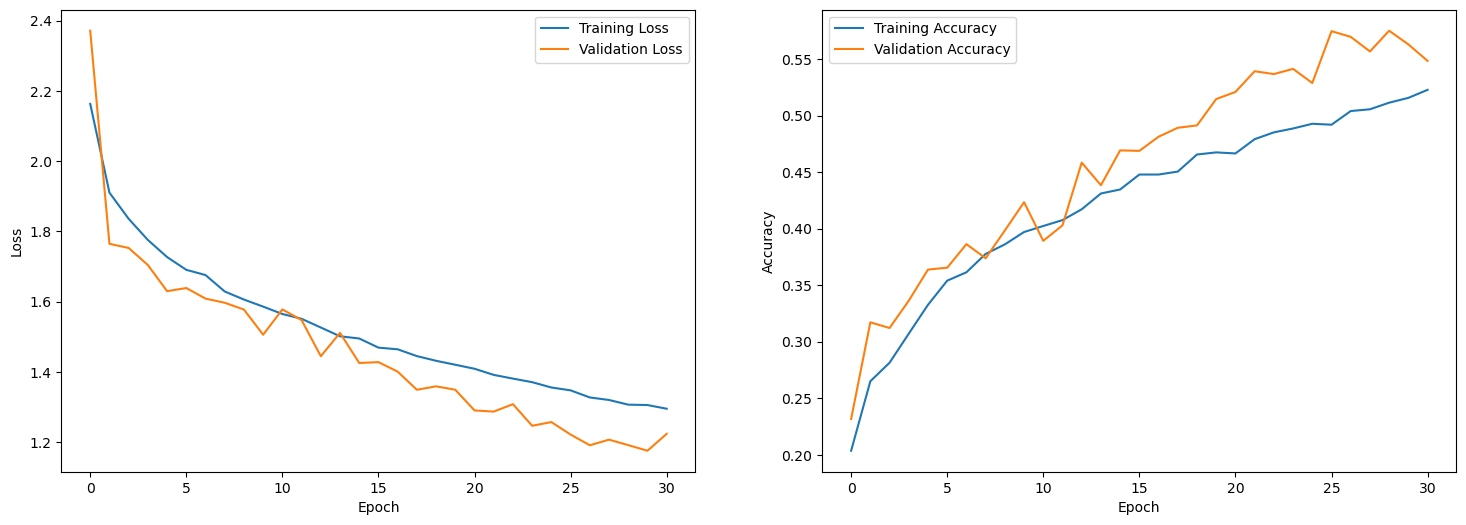

In [12]:
# callbacks
es = keras.callbacks.EarlyStopping(
    monitor="val_categorical_accuracy",
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

# train model
network_history = mlp_model.fit( 
    X_train, 
    Y_train, 
    epochs = 100,
    validation_split = 0.2,
    batch_size = 64,
    callbacks = [es]
)

# observe the training
plot_network_history(network_history)

In [13]:
# evaluate model
y_pred = np.argmax(mlp_model.predict(X_test), 1)
y_true = np.argmax(Y_test, 1)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

mlp = f1 # for future analysis

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

print()
print('Classification Report')
print(classification_report(y_true, y_pred, target_names = emotion_list.values()))

9/9 [==============================] - 0s 2ms/step
Accuracy : 0.5208333333333334
Precision: 0.5116992536170119
Recall   : 0.4910503347776197
F1 Score : 0.46981727805127305

Classification Report
              precision    recall  f1-score   support

     neutral       0.33      0.05      0.09        20
        calm       0.46      0.85      0.60        40
       happy       0.47      0.59      0.52        34
         sad       0.58      0.29      0.39        38
       angry       0.72      0.87      0.79        39
     fearful       0.50      0.48      0.49        33
   disgusted       0.30      0.32      0.31        38
   surprised       0.73      0.48      0.58        46

    accuracy                           0.52       288
   macro avg       0.51      0.49      0.47       288
weighted avg       0.53      0.52      0.50       288



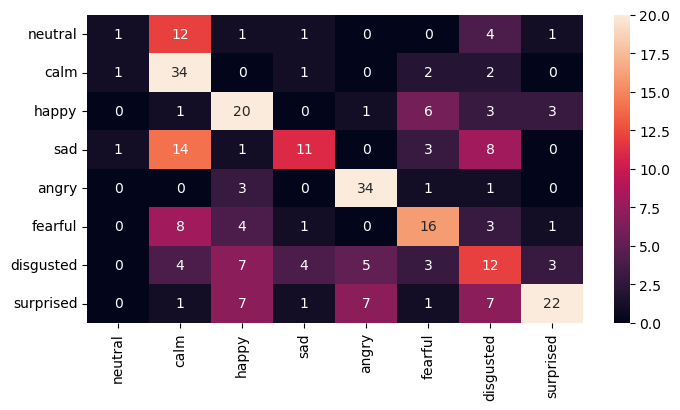

In [14]:
# confusion matrix
plt.figure(figsize=(8, 4))
conf = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels=labels, yticklabels=labels)
plt.show()

---
## Convolutional Neural Network

Convolutional neural networks use filters to process data in a grid-like topology. While they are common with image classification problems, we hope to leverage their ability to discern context and locality to identify temporal and frequency-related properties inherent in sound data.

We start by transforming our data from the two dimensional [samples * features] to [samples, features, 1]. CNN layers expect this third dimension explicitly, even if it's just a single channel.

In [15]:
# add an extra dimension to our data
X_train = np.expand_dims(X_train, -1)
X_test  = np.expand_dims(X_test, -1)

In [16]:
cnn_model = Sequential()

layers = [
    Input(shape=(X_train.shape[1], X_train.shape[2])),
     
    Conv1D(32, kernel_size=(3), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.25),
    
    Conv1D(64, kernel_size=(3), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.25),
    
    Conv1D(64, kernel_size=(3), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.25),

    Conv1D(128, kernel_size=(3), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.4),
    
    Conv1D(128, kernel_size=(3), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.4),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(num_classes, activation="softmax"),
]

cnn_model = tf.keras.Sequential(layers)
cnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

cnn_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 32)            0         
 D)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 20, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 10, 64)            0         
 g1D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 10, 64)          

Epoch 1/100
300/300 [==============================] - 4s 7ms/step - loss: 2.8325 - categorical_accuracy: 0.1287 - val_loss: 2.0702 - val_categorical_accuracy: 0.1375
Epoch 2/100
300/300 [==============================] - 2s 7ms/step - loss: 2.0786 - categorical_accuracy: 0.1446 - val_loss: 2.0634 - val_categorical_accuracy: 0.1383
Epoch 3/100
300/300 [==============================] - 2s 8ms/step - loss: 2.0675 - categorical_accuracy: 0.1495 - val_loss: 2.0590 - val_categorical_accuracy: 0.1375
Epoch 4/100
300/300 [==============================] - 2s 8ms/step - loss: 2.0464 - categorical_accuracy: 0.1648 - val_loss: 2.0227 - val_categorical_accuracy: 0.1725
Epoch 5/100
300/300 [==============================] - 2s 8ms/step - loss: 2.0160 - categorical_accuracy: 0.1870 - val_loss: 1.9875 - val_categorical_accuracy: 0.1792
Epoch 6/100
300/300 [==============================] - 2s 8ms/step - loss: 1.9876 - categorical_accuracy: 0.2062 - val_loss: 1.9669 - val_categorical_accuracy: 0.232

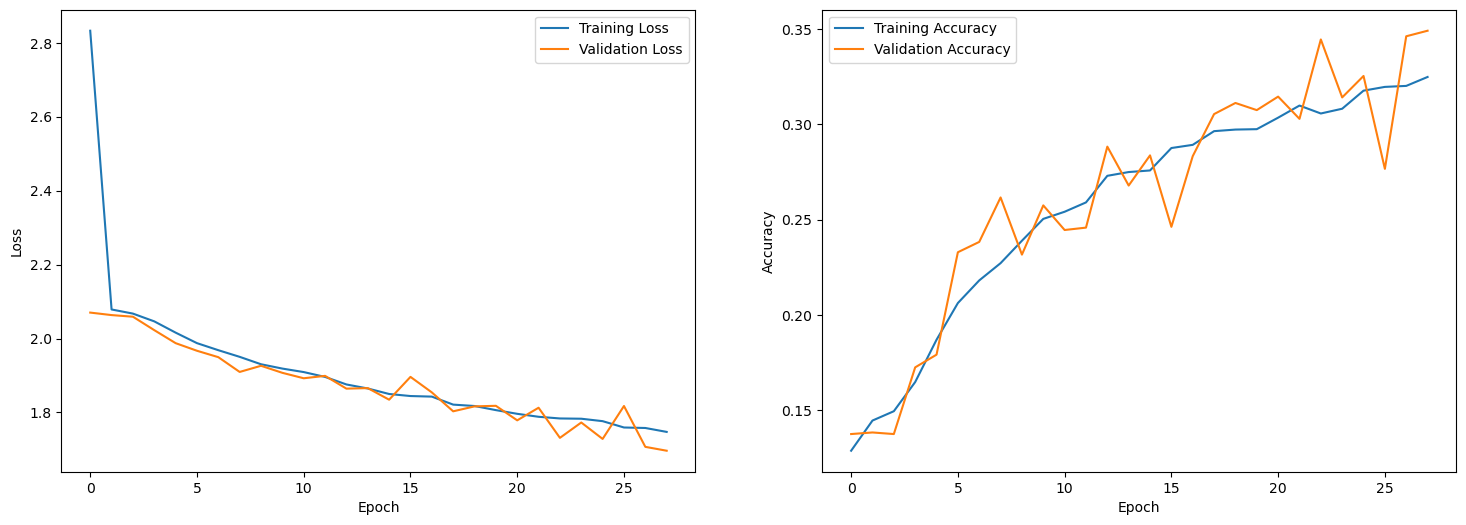

In [17]:
# callbacks
es = keras.callbacks.EarlyStopping(
    monitor="val_categorical_accuracy", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

# fit the model
network_history = cnn_model.fit( X_train, Y_train, epochs = 100, validation_split = 0.2, callbacks = [es])

# observe the training
plot_network_history(network_history)

In [18]:
# evaluate model
y_pred = np.argmax(cnn_model.predict(X_test), 1)
y_true = np.argmax(Y_test, 1)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1        = f1_score(y_true, y_pred, average='macro', zero_division=0)

cnn = f1 # for future analysis

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

print()
print('Classification Report')
print(classification_report(y_true, y_pred, target_names = emotion_list.values()))

9/9 [==============================] - 0s 4ms/step
Accuracy : 0.3472222222222222
Precision: 0.28835096758437717
Recall   : 0.31052639031000856
F1 Score : 0.25725753061900036

Classification Report
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        20
        calm       0.43      0.70      0.53        40
       happy       0.50      0.03      0.06        34
         sad       0.00      0.00      0.00        38
       angry       0.35      0.62      0.44        39
     fearful       0.50      0.30      0.38        33
   disgusted       0.12      0.18      0.15        38
   surprised       0.41      0.65      0.50        46

    accuracy                           0.35       288
   macro avg       0.29      0.31      0.26       288
weighted avg       0.30      0.35      0.28       288



C:\Users\ogiev\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ogiev\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ogiev\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


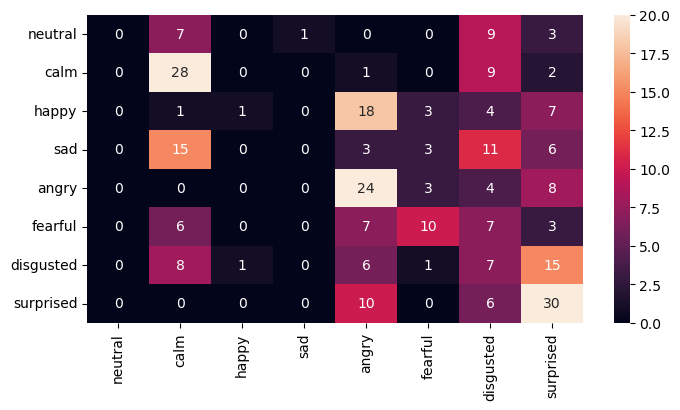

In [19]:
# confusion matrix
plt.figure(figsize=(8, 4))
conf   = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels = labels, yticklabels = labels)
plt.show()

---
## Long Short Term Memory Network

LSTM networks are a type of recurrent neural network (RNN). Because of the conventional nature of this model in solving sequence prediction problems, like text, speech and video classifications, we expect a marked improvement in performance.

In [20]:
lstm_model = Sequential()

layers = [
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(1024),
    Dense(num_classes, activation="softmax"),
]

lstm_model = tf.keras.Sequential(layers)
lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              4202496   
                                                                 
 dense_8 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 4210696 (16.06 MB)
Trainable params: 4210696 (16.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
75/75 [==============================] - 54s 683ms/step - loss: 1.9163 - categorical_accuracy: 0.2449 - val_loss: 1.8660 - val_categorical_accuracy: 0.2633 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 51s 680ms/step - loss: 1.7957 - categorical_accuracy: 0.3010 - val_loss: 1.8926 - val_categorical_accuracy: 0.2812 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 81s 1s/step - loss: 1.7569 - categorical_accuracy: 0.3201 - val_loss: 1.7047 - val_categorical_accuracy: 0.3388 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 57s 757ms/step - loss: 1.6780 - categorical_accuracy: 0.3479 - val_loss: 1.6508 - val_categorical_accuracy: 0.3688 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 52s 687ms/step - loss: 1.6205 - categorical_accuracy: 0.3728 - val_loss: 1.5873 - val_categorical_accuracy: 0.3871 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 51s 675ms/step - loss: 1.5782 - categorical_a

75/75 [==============================] - 67s 902ms/step - loss: 0.0016 - categorical_accuracy: 1.0000 - val_loss: 0.9512 - val_categorical_accuracy: 0.8029 - lr: 5.0000e-04
Epoch 46/100
75/75 [==============================] - 75s 1s/step - loss: 0.0014 - categorical_accuracy: 1.0000 - val_loss: 0.9600 - val_categorical_accuracy: 0.8037 - lr: 5.0000e-04
Epoch 47/100
75/75 [==============================] - 61s 813ms/step - loss: 0.0012 - categorical_accuracy: 1.0000 - val_loss: 0.9706 - val_categorical_accuracy: 0.8054 - lr: 5.0000e-04
Epoch 48/100
75/75 [==============================] - 67s 894ms/step - loss: 0.0010 - categorical_accuracy: 1.0000 - val_loss: 0.9787 - val_categorical_accuracy: 0.8054 - lr: 5.0000e-04
Epoch 49/100
75/75 [==============================] - 76s 1s/step - loss: 8.8443e-04 - categorical_accuracy: 1.0000 - val_loss: 0.9866 - val_categorical_accuracy: 0.8054 - lr: 5.0000e-04
Epoch 50/100
75/75 [==============================] - 76s 1s/step - loss: 7.8931e-04 

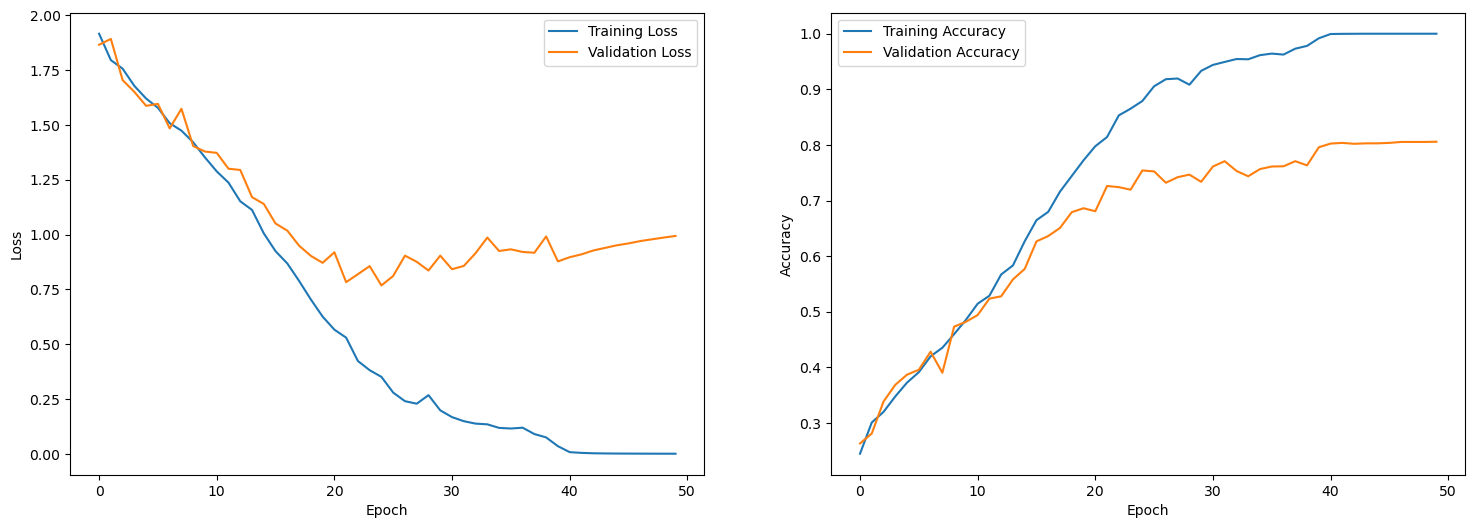

In [21]:
# callbacks
es = keras.callbacks.EarlyStopping( 
        monitor = "val_categorical_accuracy", 
        min_delta = 0.01, 
        patience = 10, 
        restore_best_weights = True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor  = "val_categorical_accuracy",
        factor   = 0.5,
        patience = 7,
        min_lr   = 1e-7,
        verbose  = 1,
)


# fit the model
network_history = lstm_model.fit(
    X_train,
    Y_train,
    epochs = 100,
    batch_size = 128,
    validation_split = 0.2,
    callbacks = [es, lr_scheduler],
)

# observe the training
plot_network_history(network_history)

In [22]:
# evaluate model
y_pred = np.argmax(lstm_model.predict(X_test), 1)
y_true = np.argmax(Y_test, 1)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

lstm = f1 # for future analysis

print()
print('Classification Report')
print(classification_report(y_true, y_pred, target_names = emotion_list.values()))

9/9 [==============================] - 2s 107ms/step
Accuracy : 0.5520833333333334
Precision: 0.5409277669365546
Recall   : 0.5449060978506395
F1 Score : 0.5415142511469081

Classification Report
              precision    recall  f1-score   support

     neutral       0.38      0.45      0.41        20
        calm       0.63      0.65      0.64        40
       happy       0.58      0.62      0.60        34
         sad       0.45      0.47      0.46        38
       angry       0.68      0.72      0.70        39
     fearful       0.44      0.45      0.45        33
   disgusted       0.55      0.47      0.51        38
   surprised       0.62      0.52      0.56        46

    accuracy                           0.55       288
   macro avg       0.54      0.54      0.54       288
weighted avg       0.56      0.55      0.55       288



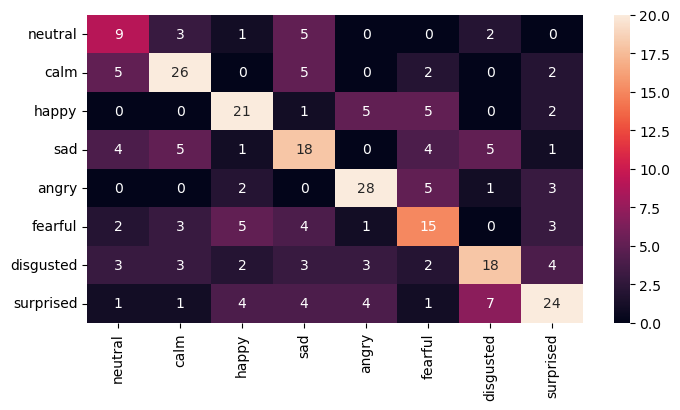

In [23]:
# confusion matrix
plt.figure(figsize=(8, 4))
conf   = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels=labels, yticklabels=labels)
plt.show()

---
## Combined (CNN + LSTM) Neural Network  
Leveraging the strengths of both the LSTM and CNN architectures in a single model might prove valuable in capturing both the textural and temporal nuances of speech.

In [24]:
comb_model = Sequential()

layers = [
    Input(shape=(X_train.shape[1], X_train.shape[2])),
     
    Conv1D(filters=200, kernel_size=3),
    BatchNormalization(),
    MaxPool1D(pool_size=2, padding="same"),
    Dropout(0.3),
    
    Conv1D(filters=200, kernel_size=3),
    BatchNormalization(),
    Dropout(0.3),
    
    Conv1D(filters=200, kernel_size=3),
    BatchNormalization(),
    MaxPool1D(pool_size=2, padding="same"),
    Dropout(0.3),
    
    LSTM(1024),
    
    Dense(128, activation="relu"),
    BatchNormalization(),
    
    Dense(num_classes, activation="softmax"),
]

comb_model = tf.keras.Sequential(layers)
comb_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

comb_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 38, 200)           800       
                                                                 
 batch_normalization_5 (Bat  (None, 38, 200)           800       
 chNormalization)                                                
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 19, 200)           0         
 g1D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 19, 200)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 17, 200)           120200    
                                                                 
 batch_normalization_6 (Bat  (None, 17, 200)          

Epoch 1/100
150/150 [==============================] - 29s 177ms/step - loss: 1.9014 - categorical_accuracy: 0.2796 - val_loss: 2.0374 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - 23s 150ms/step - loss: 1.6685 - categorical_accuracy: 0.3703 - val_loss: 1.8227 - val_categorical_accuracy: 0.3433 - lr: 0.0010
Epoch 3/100
150/150 [==============================] - 20s 136ms/step - loss: 1.5532 - categorical_accuracy: 0.4156 - val_loss: 1.4792 - val_categorical_accuracy: 0.4454 - lr: 0.0010
Epoch 4/100
150/150 [==============================] - 18s 123ms/step - loss: 1.4526 - categorical_accuracy: 0.4506 - val_loss: 1.4180 - val_categorical_accuracy: 0.4821 - lr: 0.0010
Epoch 5/100
150/150 [==============================] - 18s 120ms/step - loss: 1.3744 - categorical_accuracy: 0.4871 - val_loss: 1.3547 - val_categorical_accuracy: 0.5063 - lr: 0.0010
Epoch 6/100
150/150 [==============================] - 18s 121ms/step - loss: 1.2889 

150/150 [==============================] - 19s 129ms/step - loss: 0.0169 - categorical_accuracy: 0.9947 - val_loss: 0.9067 - val_categorical_accuracy: 0.8267 - lr: 5.0000e-04
Epoch 45/100
150/150 [==============================] - 19s 129ms/step - loss: 0.0169 - categorical_accuracy: 0.9942 - val_loss: 0.9330 - val_categorical_accuracy: 0.8196 - lr: 5.0000e-04


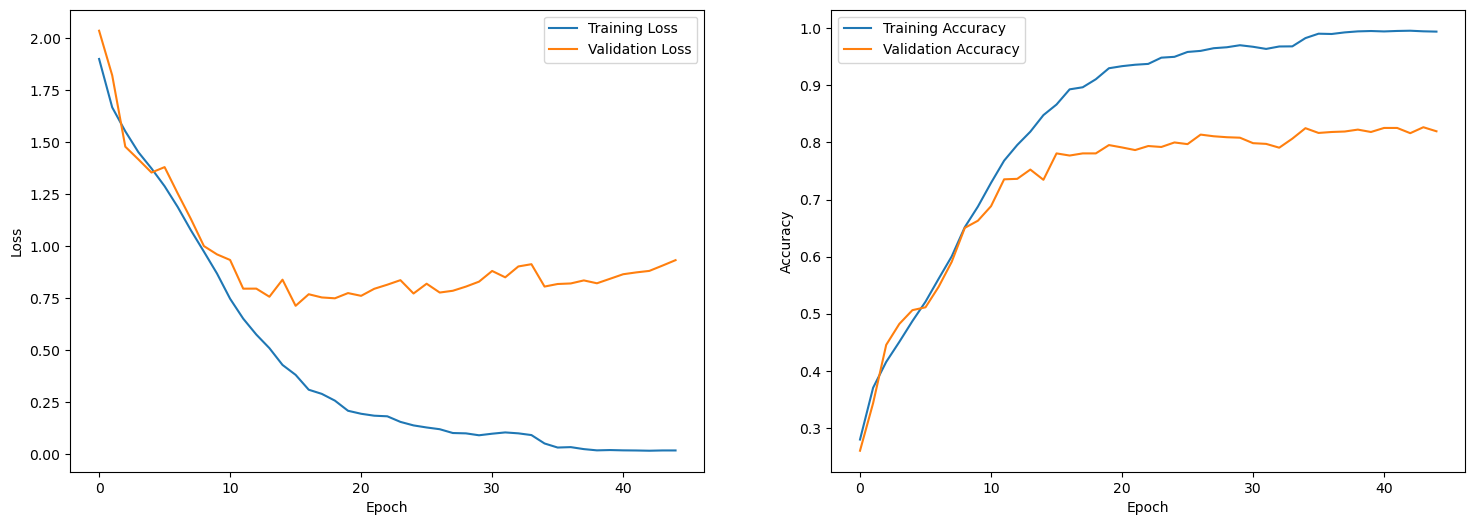

In [25]:
# callbacks
es = keras.callbacks.EarlyStopping( 
        monitor = "val_categorical_accuracy", 
        min_delta = 0.01, 
        patience = 10, 
        restore_best_weights = True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor  = "val_categorical_accuracy",
        factor   = 0.5,
        patience = 7,
        min_lr   = 1e-7,
        verbose  = 1,
)

# fit the model
network_history = comb_model.fit( 
    X_train,
    Y_train,
    epochs = 100,
    batch_size = 64,
    validation_split = 0.2,
    callbacks=[es, lr_scheduler],
)

# observe the training
plot_network_history(network_history)

In [26]:
# evaluate model
y_pred = np.argmax(comb_model.predict(X_test), 1)
y_true = np.argmax(Y_test, 1)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

combo = f1 # for future analysis

print()
print('Classification Report')
print(classification_report(y_true, y_pred, target_names = emotion_list.values()))

9/9 [==============================] - 1s 20ms/step
Accuracy : 0.6597222222222222
Precision: 0.6551155698317109
Recall   : 0.6599478128772112
F1 Score : 0.6524754496993239

Classification Report
              precision    recall  f1-score   support

     neutral       0.48      0.70      0.57        20
        calm       0.74      0.70      0.72        40
       happy       0.61      0.68      0.64        34
         sad       0.57      0.66      0.61        38
       angry       0.79      0.77      0.78        39
     fearful       0.59      0.58      0.58        33
   disgusted       0.69      0.53      0.60        38
   surprised       0.78      0.67      0.72        46

    accuracy                           0.66       288
   macro avg       0.66      0.66      0.65       288
weighted avg       0.67      0.66      0.66       288



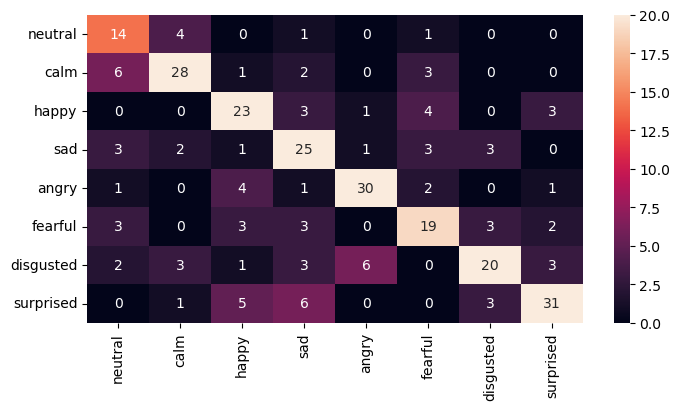

In [27]:
# confusion matrix
plt.figure(figsize=(8, 4))
conf   = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels=labels, yticklabels=labels)
plt.show()

---
## Bi-directional Long Short Term Neural Network

Bidirectional LSTMs are an extension of traditional LSTMs which provide additional context to the network. In a Bi-LSTM, input data is processed in both forward and backward directions (two LSTMs), which means that the network has information from past (backward) and future (forward) states simultaneously.

In [28]:
bi_model = Sequential()

layers = [
    Input(shape=(X_train.shape[1], X_train.shape[2])),
     
    Bidirectional(LSTM(1024, return_sequences=True)),
    Bidirectional(LSTM(1024)),
    
    Dense(num_classes, activation="softmax"),
]

bi_model = tf.keras.Sequential(layers)
bi_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

bi_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 40, 2048)          8404992   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 2048)              25174016  
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 8)                 16392     
                                                                 
Total params: 33595400 (128.16 MB)
Trainable params: 33595400 (128.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# callbacks
es = keras.callbacks.EarlyStopping( 
        monitor = "val_categorical_accuracy", 
        min_delta = 0.01, 
        patience = 10, 
        restore_best_weights = True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor  = "val_categorical_accuracy",
        factor   = 0.5,
        patience = 7,
        min_lr   = 1e-7,
        verbose  = 1,
)

# fit the model
network_history = bi_model.fit( 
    X_train,
    Y_train,
    epochs = 100,
    batch_size = 64,
    validation_split = 0.2,
    callbacks=[es, lr_scheduler],
)

# observe the training
plot_network_history(network_history)

Epoch 1/100
150/150 [==============================] - 487s 3s/step - loss: 0.6543 - categorical_accuracy: 0.7710 - val_loss: 0.8032 - val_categorical_accuracy: 0.7175 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - 431s 3s/step - loss: 0.4855 - categorical_accuracy: 0.8286 - val_loss: 0.6227 - val_categorical_accuracy: 0.7879 - lr: 0.0010
Epoch 3/100
150/150 [==============================] - 439s 3s/step - loss: 0.3390 - categorical_accuracy: 0.8849 - val_loss: 0.6432 - val_categorical_accuracy: 0.7771 - lr: 0.0010
Epoch 4/100
150/150 [==============================] - 464s 3s/step - loss: 0.2571 - categorical_accuracy: 0.9124 - val_loss: 0.5920 - val_categorical_accuracy: 0.8046 - lr: 0.0010
Epoch 5/100
150/150 [==============================] - 447s 3s/step - loss: 0.1803 - categorical_accuracy: 0.9396 - val_loss: 0.5638 - val_categorical_accuracy: 0.8279 - lr: 0.0010
Epoch 6/100
106/150 [====================>.........] - ETA: 2:21 - loss: 0.1307 - categorical_a

In [ ]:
# evaluate model
y_pred = np.argmax(bi_model.predict(X_test), 1)
y_true = np.argmax(Y_test, 1)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

bi = f1 # for future analysis

print()
print('Classification Report')
print(classification_report(y_test_labels, y_pred_labels, target_names = emotion_list.values()))

In [ ]:
# confusion matrix
plt.figure(figsize=(8, 4))
conf   = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels=labels, yticklabels=labels)
plt.show()

## Comparing the Models

In [ ]:
f1_scores = [knn, mlp, cnn, lstm, combo, bi]
models = ['kNN', 'Multilayer Perceptron', 'Convolutional Neural Network', 'Long Short Term Memory', 'CNN + LSTM', 'Bidirectional LSTM']
colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow']

plt.figure(figsize=(10, 5))
plt.bar(models, f1_scores, color=colors)
plt.title('F1 Score by Model')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.xticks(ticks=range(len(models)), labels=models, rotation=90, ha='right')
plt.gca().set_xticklabels(models, wrap=True)

plt.show()
